In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Show columns for Measurement table
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [11]:
# SAMPLE QUERY

# RAW SQL Version:
# SELECT * FROM measurement

# SQL ALCHEMY Version:
measurement_data = session.query(*Measurement.__table__.columns).all()
measurement_data[-1]

(19550, 'USC00516128', '2017-08-23', 0.45, 76.0)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_data = session.query(*Measurement.__table__.columns).all()

# Calculate the date 1 year ago from the last data point in the database
last_date = measurement_data[-1] # '2017-08-23'
year_before = '2016-08-23'

# Perform a query to retrieve the data and precipitation scores
# RAW SQL Version:
# SELECT measurement.date, measurement.prcp
# FROM measurement 
# WHERE measurement.date >= year_before

# SQL ALCHEMY Version:
yb_precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_before).all()
yb_precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column
yb_precip_df = pd.DataFrame(yb_precip_data)
yb_precip_df.head(20)

# Sort the dataframe by date (is sorted!)

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
5,2016-08-28,0.01
6,2016-08-29,0.00
7,2016-08-30,0.00
8,2016-08-31,0.13
9,2016-09-01,0.00


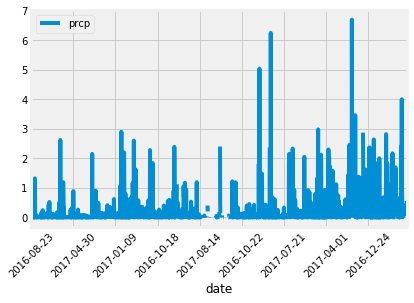

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
yb_precip_df.plot(x='date', y='prcp', rot=45)


![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
yb_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Show columns for Measurement table
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).all()
stations = len(stations)
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_by_activity = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station)\
                        .desc()).all()
stations_by_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
most_active_station_data

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# most active stations -> 'USC00519281'
# year_before -> '2016-08-23'
most_active_tobs = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').all()

In [20]:
most_active_tobs_df = pd.DataFrame(most_active_tobs)
most_active_tobs_df.head(5)

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


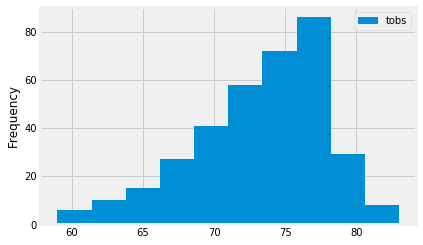

In [21]:
most_active_tobs_df.plot.hist()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-01-01', '2017-01-10')
temps

[(60.0, 68.0327868852459, 77.0)]

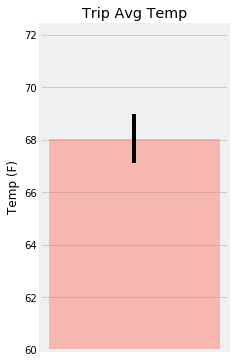

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='salmon', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by('rainfall').all()

rainfall('2017-01-01', '2017-01-10')


[('USC00517948', None, 21.3934, -157.9751, 11.9),
 ('USC00519523', None, 21.33556, -157.71139, 19.5),
 ('USC00514830', 0.0, 21.5213, -157.8374, 7.0),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00516128', 0.03, 21.3331, -157.8025, 152.4),
 ('USC00519281', 0.03, 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 0.29, 21.4234, -157.8015, 14.6)]